**WORKING CHANGED TALKING POINTS**

In [0]:
# PRODUCTION PREDICTIONS: Single-Policy Clients
# ============================================================================
# STANDALONE CELL - Can be used independently in a separate notebook
# 
# This cell:
# 1. Gets most recent business_month and filters to branchoffice_code 83
# 2. Selects axa_party_id with exactly 1 policy (to predict their second product)
# 3. Uses exact preprocessing steps from validation notebook
# 4. Makes predictions using eda_smartlist.models.lgbm_model_hyperparameter_axa_fulldata_last2products
# 5. Performs SHAP analysis and generates enhanced talking points

# ============================================================================
# IMPORTS
# ============================================================================
import os
import pickle
from typing import Dict, Any

import mlflow
import numpy as np
import pandas as pd
import shap
from mlflow.tracking import MlflowClient
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import current_date, datediff, col, concat_ws

# ============================================================================
# CONFIGURATION
# ============================================================================
TABLE_NAME = "dl_tenants_daas.us_wealth_management.wealth_management_client_metrics"
BRANCHOFFICE_CODE = "83"
MODEL_NAME = "eda_smartlist.models.lgbm_model_hyperparameter_axa_fulldata_last2products"
MODEL_VERSION = "1"
ARTIFACTS_LOCAL_PATH = "/Workspace/EDA_workspace/RA Smart List/Smart List (NEW)/multiproduct_smartlist/Final_model_files/artifacts.pkl"

# ============================================================================
# PREPROCESSING HELPER FUNCTIONS
# ============================================================================

def create_product_category_column(df):
    """Create product_category column from prod_lob, sub_product_level_1, and sub_product_level_2."""
    return df.withColumn(
        "product_category",
        F.when(F.col("prod_lob") == "LIFE", "LIFE_INSURANCE")
        .when(
            F.col("sub_product_level_1").isin(
                "VLI", "WL", "UL/IUL", "TERM", "PROTECTIVE PRODUCT"
            ),
            "LIFE_INSURANCE",
        )
        .when(F.col("sub_product_level_2").like("%LIFE%"), "LIFE_INSURANCE")
        .when(
            F.col("sub_product_level_2").isin(
                "VARIABLE UNIVERSAL LIFE",
                "WHOLE LIFE",
                "UNIVERSAL LIFE",
                "INDEX UNIVERSAL LIFE",
                "TERM PRODUCT",
                "VARIABLE LIFE",
                "SURVIVORSHIP WHOLE LIFE",
                "MONY PROTECTIVE PRODUCT",
            ),
            "LIFE_INSURANCE",
        )
        .when(
            F.col("prod_lob").isin("GROUP RETIREMENT", "INDIVIDUAL RETIREMENT"),
            "RETIREMENT",
        )
        .when(
            F.col("sub_product_level_1").isin(
                "EQUIVEST",
                "RETIREMENT 401K",
                "ACCUMULATOR",
                "RETIREMENT CORNERSTONE",
                "SCS",
                "INVESTMENT EDGE",
            ),
            "RETIREMENT",
        )
        .when(
            (F.col("sub_product_level_2").like("%403B%"))
            | (F.col("sub_product_level_2").like("%401%"))
            | (F.col("sub_product_level_2").like("%IRA%"))
            | (F.col("sub_product_level_2").like("%SEP%")),
            "RETIREMENT",
        )
        .when(F.col("prod_lob") == "BROKER DEALER", "INVESTMENT")
        .when(
            F.col("sub_product_level_1").isin(
                "INVESTMENT PRODUCT - DIRECT",
                "INVESTMENT PRODUCT - BROKERAGE",
                "INVESTMENT PRODUCT - ADVISORY",
                "DIRECT",
                "BROKERAGE",
                "ADVISORY",
                "CASH SOLICITOR",
            ),
            "INVESTMENT",
        )
        .when(
            (F.col("sub_product_level_2").like("%Investment%"))
            | (F.col("sub_product_level_2").like("%Brokerage%"))
            | (F.col("sub_product_level_2").like("%Advisory%")),
            "INVESTMENT",
        )
        .when(F.col("prod_lob") == "NETWORK", "NETWORK_PRODUCTS")
        .when(
            (F.col("sub_product_level_1") == "NETWORK PRODUCTS")
            | (F.col("sub_product_level_2") == "NETWORK PRODUCTS"),
            "NETWORK_PRODUCTS",
        )
        .when(
            (F.col("prod_lob") == "OTHERS")
            & (F.col("sub_product_level_1") == "HAS"),
            "DISABILITY",
        )
        .when(F.col("sub_product_level_2") == "HAS - DISABILITY", "DISABILITY")
        .when(F.col("prod_lob") == "OTHERS", "HEALTH")
        .when(F.col("sub_product_level_2") == "GROUP HEALTH PRODUCTS", "HEALTH")
        .otherwise("OTHER"),
    )


def add_asset_allocation_ratios(df):
    """Add asset allocation ratio features based on wealth metrics."""
    df = df.withColumn(
        "stock_allocation_ratio",
        F.col("wc_assetmix_stocks")
        / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(
            F.lit(None)
        ),
    )
    df = df.withColumn(
        "bond_allocation_ratio",
        F.col("wc_assetmix_bonds")
        / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(
            F.lit(None)
        ),
    )
    df = df.withColumn(
        "annuity_allocation_ratio",
        F.col("wc_assetmix_annuity")
        / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(
            F.lit(None)
        ),
    )
    df = df.withColumn(
        "mutual_fund_allocation_ratio",
        F.col("wc_assetmix_mutual_funds")
        / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(
            F.lit(None)
        ),
    )
    return df


def impute_missing_values(df, categorical_cols, categorical_mode="UNKNOWN"):
    """Impute missing values in DataFrame."""
    numeric_cols = [
        "first_acct_val_amt",
        "first_face_amt",
        "first_cash_val_amt",
        "wc_total_assets",
        "wc_assetmix_stocks",
        "wc_assetmix_bonds",
        "wc_assetmix_mutual_funds",
        "wc_assetmix_annuity",
        "wc_assetmix_deposits",
        "wc_assetmix_other_assets",
        "psn_age",
        "stock_allocation_ratio",
        "bond_allocation_ratio",
        "annuity_allocation_ratio",
        "mutual_fund_allocation_ratio",
        "age_at_first_policy",
        "years_to_second_policy",
    ]

    # Median imputation for numeric columns
    fill_numeric = {}
    for c in numeric_cols:
        if c in df.columns:
            try:
                median_val = df.approxQuantile(c, [0.5], 0.001)[0]
            except Exception:
                median_val = 0.0
            if median_val is None:
                median_val = 0.0
            fill_numeric[c] = float(median_val)

    result_df = df.fillna(fill_numeric)

    # Mode imputation for categoricals
    for c in categorical_cols:
        if c in result_df.columns:
            try:
                mode_row = (
                    result_df.groupBy(c)
                    .count()
                    .orderBy(F.desc("count"))
                    .first()
                )
                mode_val = (
                    mode_row[0]
                    if mode_row and mode_row[0] is not None
                    else categorical_mode
                )
            except Exception:
                mode_val = categorical_mode

            result_df = result_df.withColumn(
                c,
                F.when(F.col(c).isNull(), F.lit(mode_val)).otherwise(F.col(c)),
            )

    return result_df


def encode_categorical_features(df, categorical_cols, spark_context, categorical_mappings=None):
    """Encode categorical features to integer indices."""
    if categorical_mappings is None:
        categorical_mappings = {}

    result_df = df

    for c in categorical_cols:
        if c in categorical_mappings:
            mapping = categorical_mappings[c]
            b = spark_context.broadcast(mapping)
            result_df = result_df.withColumn(
                c + "_idx",
                F.udf(lambda s: int(b.value.get(str(s), 0)), IntegerType())(
                    F.coalesce(F.col(c).cast("string"), F.lit("UNKNOWN"))
                ),
            )
        else:
            vals = [r[0] for r in result_df.select(c).distinct().collect()]
            mapping = {v: i for i, v in enumerate(sorted([str(x) for x in vals]))}
            categorical_mappings[c] = mapping

            b = spark_context.broadcast(mapping)
            result_df = result_df.withColumn(
                c + "_idx",
                F.udf(lambda s: int(b.value.get(str(s), 0)), IntegerType())(
                    F.coalesce(F.col(c).cast("string"), F.lit("UNKNOWN"))
                ),
            )

    return result_df, categorical_mappings


def get_feature_columns():
    """Get the list of feature columns in the correct order."""
    return [
        "first_acct_val_amt",
        "first_face_amt",
        "first_cash_val_amt",
        "wc_total_assets",
        "wc_assetmix_stocks",
        "wc_assetmix_bonds",
        "wc_assetmix_mutual_funds",
        "wc_assetmix_annuity",
        "wc_assetmix_deposits",
        "wc_assetmix_other_assets",
        "psn_age",
        "stock_allocation_ratio",
        "bond_allocation_ratio",
        "annuity_allocation_ratio",
        "mutual_fund_allocation_ratio",
        "age_at_first_policy",
        "years_to_second_policy",
        "first_product_category_idx",
        "client_seg_idx",
        "client_seg_1_idx",
        "aum_band_idx",
        "channel_idx",
        "agent_segment_idx",
        "branchoffice_code_idx",
        "season_of_first_policy_idx",
    ]


# ============================================================================
# MODEL LOADING FUNCTION
# ============================================================================

def load_model_and_artifacts() -> Dict[str, Any]:
    """Load the LightGBM model and its preprocessing artifacts."""
    client = MlflowClient()

    # Load registered LightGBM model
    model_uri = f"models:/{MODEL_NAME}/{MODEL_VERSION}"
    print(f"Loading model from {model_uri}...")
    lgbm_model = mlflow.lightgbm.load_model(model_uri)
    print("✓ Model loaded successfully")

    # Try to load artifacts from local path first
    artifacts = None
    if ARTIFACTS_LOCAL_PATH and os.path.exists(ARTIFACTS_LOCAL_PATH):
        print(f"Loading artifacts from local path: {ARTIFACTS_LOCAL_PATH}")
        with open(ARTIFACTS_LOCAL_PATH, "rb") as f:
            artifacts = pickle.load(f)
        print("✓ Artifacts loaded from local path")
    else:
        # Try MLflow run artifacts
        try:
            mv = client.get_model_version(name=MODEL_NAME, version=MODEL_VERSION)
            run_id = mv.run_id
            print(f"Attempting to download artifacts from run {run_id}...")
            artifacts_dir = mlflow.artifacts.download_artifacts(
                artifact_uri=f"runs:/{run_id}/artifacts"
            )
            artifacts_path = os.path.join(artifacts_dir, "artifacts.pkl")
            if os.path.exists(artifacts_path):
                with open(artifacts_path, "rb") as f:
                    artifacts = pickle.load(f)
                print("✓ Artifacts loaded from MLflow")
        except Exception as e:
            print(f"⚠ Could not load artifacts from MLflow: {e}")

    if artifacts is None:
        raise FileNotFoundError(
            f"Could not find artifacts.pkl. Please ensure it exists at {ARTIFACTS_LOCAL_PATH} "
            "or is available in MLflow."
        )

    prod2id = artifacts.get("prod2id")
    id2prod = artifacts.get("id2prod")
    label_map = artifacts.get("label_map")
    num_classes = artifacts.get("num_classes")
    categorical_mappings = artifacts.get("categorical_mappings")
    feature_cols = artifacts.get("feature_cols") or get_feature_columns()

    if prod2id is None or id2prod is None:
        raise ValueError("prod2id/id2prod mappings missing in artifacts.pkl")
    if label_map is None:
        raise ValueError("label_map missing in artifacts.pkl")

    print("✓ All artifacts loaded successfully")
    return {
        "model": lgbm_model,
        "prod2id": prod2id,
        "id2prod": id2prod,
        "label_map": label_map,
        "num_classes": num_classes,
        "categorical_mappings": categorical_mappings,
        "feature_cols": feature_cols,
    }


# ============================================================================
# MAIN PRODUCTION PIPELINE
# ============================================================================

print("=" * 80)
print("PRODUCTION PREDICTIONS FOR SINGLE-POLICY CLIENTS")
print("=" * 80)

# Initialize Spark
spark = SparkSession.builder.getOrCreate()

# ---------------------------------------------------------------------------
# Step 1: Get most recent business_month and filter data
# ---------------------------------------------------------------------------

# Get most recent business_month
max_business_month = spark.table(TABLE_NAME).agg(F.max("business_month")).first()[0]
print(f"\n✓ Using most recent business_month: {max_business_month}")
print(f"✓ Filtering to branchoffice_code: {BRANCHOFFICE_CODE}")

# Load and filter data
df_raw = spark.table(TABLE_NAME)
df_raw = df_raw.filter(F.col("business_month") == max_business_month)
df_raw = df_raw.filter(F.col("branchoffice_code") == BRANCHOFFICE_CODE)
df_raw = df_raw.filter(F.col("policy_status") == "Active")

# Create product_category
df_raw = create_product_category_column(df_raw)

# ---------------------------------------------------------------------------
# Step 2: Filter to axa_party_id with exactly 1 policy
# ---------------------------------------------------------------------------
df_events = df_raw.select(
    "axa_party_id",
    "product_category",
    "register_date",
    "isrd_brth_date",
    "acct_val_amt",
    "face_amt",
    "cash_val_amt",
    "wc_total_assets",
    "wc_assetmix_stocks",
    "wc_assetmix_bonds",
    "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity",
    "wc_assetmix_deposits",
    "wc_assetmix_other_assets",
    "psn_age",
    "client_seg",
    "client_seg_1",
    "aum_band",
    "channel",
    "agent_segment",
    "branchoffice_code",
    "policy_no",
).filter(
    (F.col("axa_party_id").isNotNull())
    & (F.col("register_date").isNotNull())
    & (F.col("product_category").isNotNull())
)

# Count policies per axa_party_id
party_counts = (
    df_events.groupBy("axa_party_id")
    .agg(F.countDistinct("policy_no").alias("policy_count"))
    .filter(F.col("policy_count") == 1)  # Exactly 1 policy
)

print(f"✓ Found {party_counts.count():,} axa_party_id with exactly 1 policy")

# Filter to single-policy clients
df_single_policy = df_events.join(
    party_counts.select("axa_party_id"), on="axa_party_id", how="inner"
)

print(f"✓ Filtered to {df_single_policy.count():,} records (single-policy clients before dedup)")

# Ensure one row per policy/client (remove technical duplicates)
df_single_policy = df_single_policy.dropDuplicates(["axa_party_id"])

print(f"✓ Filtered to {df_single_policy.count():,} records after dropping duplicate axa_party_id")

# ---------------------------------------------------------------------------
# Step 3: Preprocess data (treating single policy as "first policy")
# ---------------------------------------------------------------------------
print("\n" + "=" * 80)
print("PREPROCESSING DATA (Exact steps from validation notebook)")
print("=" * 80)

# Convert dates
df_single_policy = df_single_policy.withColumn("register_ts", F.to_timestamp("register_date"))
df_single_policy = df_single_policy.withColumn("birth_ts", F.to_timestamp("isrd_brth_date"))

# Create "first policy" features (treating single policy as first)
df_first = df_single_policy.select(
    "axa_party_id",
    F.col("product_category").alias("first_product_category"),
    F.col("register_ts").alias("first_register_ts"),
    "birth_ts",
    F.col("acct_val_amt").alias("first_acct_val_amt"),
    F.col("face_amt").alias("first_face_amt"),
    F.col("cash_val_amt").alias("first_cash_val_amt"),
    "wc_total_assets",
    "wc_assetmix_stocks",
    "wc_assetmix_bonds",
    "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity",
    "wc_assetmix_deposits",
    "wc_assetmix_other_assets",
    "psn_age",
    "client_seg",
    "client_seg_1",
    "aum_band",
    "channel",
    "agent_segment",
    "branchoffice_code",
)

# For single-policy clients, years_to_second_policy = time since first policy (current - first)
# This represents how long they've had their single policy
df_first = df_first.withColumn(
    "second_register_ts", F.current_timestamp()  # Use current timestamp as "second" reference
)

# Add asset allocation ratios
df_first = add_asset_allocation_ratios(df_first)

# Add temporal features
df_first = df_first.withColumn(
    "season_of_first_policy",
    F.when(F.month("first_register_ts").between(1, 3), "Q1")
    .when(F.month("first_register_ts").between(4, 6), "Q2")
    .when(F.month("first_register_ts").between(7, 9), "Q3")
    .when(F.month("first_register_ts").between(10, 12), "Q4")
    .otherwise("Unknown"),
)

df_first = df_first.withColumn(
    "age_at_first_policy",
    F.datediff(F.col("first_register_ts"), F.col("birth_ts")) / 365.25,
)

df_first = df_first.withColumn(
    "years_to_second_policy",
    F.datediff(F.col("second_register_ts"), F.col("first_register_ts")) / 365.25,
)

# Impute missing values
categorical_cols = [
    "first_product_category",
    "client_seg",
    "client_seg_1",
    "aum_band",
    "channel",
    "agent_segment",
    "branchoffice_code",
    "season_of_first_policy",
]

df_first = impute_missing_values(df_first, categorical_cols)

# Load model and artifacts for encoding
ctx = load_model_and_artifacts()
categorical_mappings = ctx["categorical_mappings"]
feature_cols = ctx["feature_cols"]

# Encode categorical features
df_encoded, _ = encode_categorical_features(
    df_first,
    categorical_cols,
    spark.sparkContext,
    categorical_mappings=categorical_mappings,
)

# Convert to pandas
select_cols = ["axa_party_id"] + feature_cols
pred_pd = df_encoded.select(select_cols).toPandas()
pred_pd.fillna(0, inplace=True)

print(f"✓ Preprocessed {len(pred_pd):,} single-policy clients")
print(f"✓ Feature columns: {len(feature_cols)}")

# ---------------------------------------------------------------------------
# Step 4: Make predictions
# ---------------------------------------------------------------------------
print("\n" + "=" * 80)
print("MAKING PREDICTIONS")
print("=" * 80)

model = ctx["model"]
prod2id = ctx["prod2id"]
id2prod = ctx["id2prod"]
label_map = ctx["label_map"]

X = pred_pd[feature_cols]
prob_matrix = model.predict(X)
pred_class_ids = np.argmax(prob_matrix, axis=1)

# Map predictions to product names
inv_label_map = {v: k for k, v in label_map.items()}
final_id2prod = {
    model_id: id2prod[orig_id]
    for model_id, orig_id in inv_label_map.items()
    if orig_id in id2prod
}

pred_products = [
    final_id2prod.get(int(cid), id2prod.get(int(cid), "UNKNOWN"))
    for cid in pred_class_ids
]

# Add predictions to dataframe
pred_pd["pred_class_id"] = pred_class_ids
pred_pd["pred_product"] = pred_products

num_classes_model = prob_matrix.shape[1]
for i in range(num_classes_model):
    pred_pd[f"prob_{i}"] = prob_matrix[:, i]

pred_pd["pred_prob"] = pred_pd.apply(
    lambda r: r[f"prob_{int(r['pred_class_id'])}"], axis=1
)

print(f"✓ Predictions complete for {len(pred_pd):,} clients")
print(f"\n  Top predicted products:")
top_products = pred_pd["pred_product"].value_counts().head(10)
for product, count in top_products.items():
    print(f"    {product}: {count:,} ({count/len(pred_pd)*100:.1f}%)")

# ---------------------------------------------------------------------------
# Step 5: SHAP Analysis and Enhanced Talking Points Generation
# ---------------------------------------------------------------------------
print("\n" + "=" * 80)
print("Generating Talking Points with SHAP Analysis")
print("=" * 80)

try:
    # Get the underlying LightGBM model for SHAP
    lgbm_model = model
    
    # Use all predictions for SHAP (or sample if too large)
    SHAP_SAMPLE_SIZE = len(pred_pd)
    
    print(f"Computing SHAP values for {SHAP_SAMPLE_SIZE} samples...")
    
    # Get sample axa_party_id
    sample_axa_party_id = pred_pd['axa_party_id'].head(SHAP_SAMPLE_SIZE).tolist()
    df_sample = df_single_policy.filter(F.col("axa_party_id").isin(sample_axa_party_id))
    
    # Re-preprocess to get feature values (using same preprocessing as before)
    print("Re-preprocessing sample data to get feature values...")
    
    # Apply same preprocessing steps
    df_sample_processed = df_sample.select(
        "axa_party_id",
        F.col("product_category").alias("first_product_category"),
        F.col("register_ts").alias("first_register_ts"),
        "birth_ts",
        F.col("acct_val_amt").alias("first_acct_val_amt"),
        F.col("face_amt").alias("first_face_amt"),
        F.col("cash_val_amt").alias("first_cash_val_amt"),
        "wc_total_assets",
        "wc_assetmix_stocks",
        "wc_assetmix_bonds",
        "wc_assetmix_mutual_funds",
        "wc_assetmix_annuity",
        "wc_assetmix_deposits",
        "wc_assetmix_other_assets",
        "psn_age",
        "client_seg",
        "client_seg_1",
        "aum_band",
        "channel",
        "agent_segment",
        "branchoffice_code",
    )
    
    df_sample_processed = df_sample_processed.withColumn(
        "second_register_ts", F.current_timestamp()
    )
    
    df_sample_processed = add_asset_allocation_ratios(df_sample_processed)
    
    df_sample_processed = df_sample_processed.withColumn(
        "season_of_first_policy",
        F.when(F.month("first_register_ts").between(1, 3), "Q1")
        .when(F.month("first_register_ts").between(4, 6), "Q2")
        .when(F.month("first_register_ts").between(7, 9), "Q3")
        .when(F.month("first_register_ts").between(10, 12), "Q4")
        .otherwise("Unknown"),
    )
    
    df_sample_processed = df_sample_processed.withColumn(
        "age_at_first_policy",
        F.datediff(F.col("first_register_ts"), F.col("birth_ts")) / 365.25,
    )
    
    df_sample_processed = df_sample_processed.withColumn(
        "years_to_second_policy",
        F.datediff(F.col("second_register_ts"), F.col("first_register_ts")) / 365.25,
    )
    
    categorical_cols = [
        "first_product_category",
        "client_seg",
        "client_seg_1",
        "aum_band",
        "channel",
        "agent_segment",
        "branchoffice_code",
        "season_of_first_policy",
    ]
    
    df_sample_processed = impute_missing_values(df_sample_processed, categorical_cols)
    df_sample_encoded, _ = encode_categorical_features(
        df_sample_processed,
        categorical_cols,
        spark.sparkContext,
        categorical_mappings=categorical_mappings,
    )
    
    # Convert to pandas
    pred_pd_sample = df_sample_encoded.select(["axa_party_id"] + feature_cols).toPandas()
    pred_pd_sample.fillna(0, inplace=True)
    
    # Get feature columns
    feature_cols_shap = feature_cols
    
    # Compute SHAP values
    print("Computing SHAP values...")
    explainer = shap.TreeExplainer(lgbm_model)
    shap_values = explainer.shap_values(pred_pd_sample[feature_cols_shap])

    # Get predictions for the sample to determine which class SHAP values to use
    pred_probs_sample = lgbm_model.predict(pred_pd_sample[feature_cols_shap])
    pred_class_ids_sample = np.argmax(pred_probs_sample, axis=1)
    
    # Handle SHAP output format (list of arrays or 3D array for multiclass)
    print(f"  SHAP values type: {type(shap_values)}, shape: {shap_values.shape if isinstance(shap_values, np.ndarray) else [len(x) if isinstance(x, np.ndarray) else 'N/A' for x in shap_values] if isinstance(shap_values, list) else 'N/A'}")
    
    if isinstance(shap_values, list):
        # List of arrays: one array per class, each with shape (n_samples, n_features)
        num_classes_shap = len(shap_values)
        print(f"  Detected list format with {num_classes_shap} classes")
        # Extract SHAP values for the predicted class for each sample
        shap_array = np.array([shap_values[pred_class_ids_sample[i]][i] for i in range(len(pred_pd_sample))])
    elif isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
        # 3D array: could be (n_samples, n_features, n_classes) or (n_classes, n_samples, n_features)
        n_samples, n_features, n_classes = shap_values.shape
        print(f"  Detected 3D array format: ({n_samples}, {n_features}, {n_classes})")
        # Try (n_samples, n_features, n_classes) format first
        if n_samples == len(pred_pd_sample) and n_features == len(feature_cols_shap):
            # Shape is (n_samples, n_features, n_classes)
            shap_array = np.array([shap_values[i, :, pred_class_ids_sample[i]] for i in range(n_samples)])
        elif n_classes == len(pred_pd_sample) and n_samples == len(feature_cols_shap):
            # Shape might be (n_features, n_samples, n_classes) - transpose
            shap_values = shap_values.transpose(1, 0, 2)  # Now (n_samples, n_features, n_classes)
            shap_array = np.array([shap_values[i, :, pred_class_ids_sample[i]] for i in range(len(pred_pd_sample))])
        else:
            # Try alternative: (n_classes, n_samples, n_features)
            shap_values_reshaped = shap_values.transpose(1, 2, 0)  # (n_samples, n_classes, n_features)
            shap_array = np.array([shap_values_reshaped[i, pred_class_ids_sample[i], :] for i in range(len(pred_pd_sample))])
    else:
        # Single 2D array (binary classification or single output)
        print(f"  Detected 2D array format")
        shap_array = shap_values
    
    print(f"✓ Computed SHAP values: {shap_array.shape}")
    print(f"  Expected shape: (n_samples={len(pred_pd_sample)}, n_features={len(feature_cols_shap)})")
    
    # Validate shape
    if shap_array.shape[0] != len(pred_pd_sample):
        raise ValueError(f"SHAP array first dimension ({shap_array.shape[0]}) doesn't match number of samples ({len(pred_pd_sample)})")
    if shap_array.shape[1] != len(feature_cols_shap):
        raise ValueError(f"SHAP array second dimension ({shap_array.shape[1]}) doesn't match number of features ({len(feature_cols_shap)})")

    # Enhanced talking point templates with context and actions (from cell 17 of training notebook)
    ENHANCED_TEMPLATES = {
    'first_acct_val_amt': {
        'base': 'First policy account value: ${value:,.0f}',
        'context': lambda v: 'strong capacity' if v > 50000 else 'good capacity' if v > 25000 else 'moderate capacity',
        'action': 'Discuss portfolio diversification'
    },
    'first_face_amt': {
        'base': 'First policy face amount: ${value:,.0f}',
        'context': 'significant coverage',
        'action': 'Review coverage adequacy'
    },
    'first_cash_val_amt': {
        'base': 'First policy cash value: ${value:,.0f}',
        'context': 'accumulated value',
        'action': 'Optimize cash value growth'
    },
    'wc_total_assets': {
        'base': 'Total assets: ${value:,.0f}',
        'context': lambda v: 'high net worth client' if v > 100000 else 'substantial assets',
        'action': 'Explore comprehensive wealth planning'
    },
    'stock_allocation_ratio': {
        'base': 'Stock allocation: {value:.1%}',
        'context': 'equity-focused portfolio',
        'action': 'Position growth products'
    },
    'bond_allocation_ratio': {
        'base': 'Bond allocation: {value:.1%}',
        'context': 'fixed-income focus',
        'action': 'Balance with growth opportunities'
    },
    'annuity_allocation_ratio': {
        'base': 'Annuity allocation: {value:.1%}',
        'context': 'income-focused strategy',
        'action': 'Expand retirement income solutions'
    },
    'mutual_fund_allocation_ratio': {
        'base': 'Mutual fund allocation: {value:.1%}',
        'context': 'diversified investment approach',
        'action': 'Explore additional diversification'
    },
    'age_at_first_policy': {
        'base': 'Age at first policy: {value:.0f}',
        'context': lambda v: 'retirement planning window' if v > 55 else 'wealth accumulation phase' if v > 40 else 'early career',
        'action': lambda v: 'Focus on retirement readiness' if v > 55 else 'Emphasize long-term growth'
    },
    'years_to_second_policy': {
        'base': lambda v: 'First policy client' if v == 0 or v == 0.0 else f'Time since first policy: {v:.1f} years',
        'context': lambda v: 'new client opportunity' if v == 0 or v == 0.0 else ('active engagement' if v < 3 else 'strategic planning' if v < 10 else 'long-term relationship'),
        'action': lambda v: 'Build initial relationship' if v == 0 or v == 0.0 else ('Build on engagement momentum' if v < 3 else 'Deepen relationship')
    },
    'season_of_first_policy': {
        'base': 'First policy season: {value}',
        'context': 'strategic timing',
        'action': 'Leverage planning cycles'
    },
    'first_product_category': {
        'base': 'Current product: {value}',
        'context': 'current portfolio foundation',
        'action': 'Build on existing relationship'
    },
    'psn_age': {
        'base': 'Age: {value:.0f}',
        'context': lambda v: 'retirement planning window' if v > 55 else 'wealth accumulation phase' if v > 40 else 'early career',
        'action': lambda v: 'Focus on retirement readiness' if v > 55 else 'Emphasize long-term growth'
    },
    'client_seg': {
        'base': 'Client segment: {value}',
        'context': 'targeted service tier',
        'action': 'Customize approach to segment'
    },
    'aum_band': {
        'base': 'AUM band: {value}',
        'context': 'asset level indicator',
        'action': 'Tailor recommendations to asset level'
    },
        'channel': {
            'base': 'Channel: {value}',
            'context': lambda v: 'advisor relationship' if 'Advisor' in str(v) else 'direct channel',
            'action': lambda v: 'Leverage advisor trust' if 'Advisor' in str(v) else 'Personal outreach approach'
        },
        'channel_idx': {
            'base': 'Channel: {value}',
            'context': lambda v: 'advisor relationship' if 'Advisor' in str(v) else 'direct channel',
            'action': lambda v: 'Leverage advisor trust' if 'Advisor' in str(v) else 'Personal outreach approach'
        },
        'client_tenure_years': {
            'base': '{value:.0f} years with us',
            'context': lambda v: 'long-standing relationship' if v > 10 else 'established client' if v > 5 else 'newer client',
            'action': lambda v: 'Deepen existing relationship' if v > 5 else 'Build trust and engagement'
        },
        'client_tenure': {
            'base': '{value:.1f} years with us',
            'context': lambda v: 'long-standing relationship' if v > 10 else 'established client' if v > 5 else 'newer client',
            'action': lambda v: 'Deepen existing relationship' if v > 5 else 'Build trust and engagement'
        },
        'hist_': {
            'base': 'Recent purchase history: {value}',
            'context': 'strong engagement pattern',
            'action': 'Build on existing relationship'
        },
        'last_1': {
            'base': 'Most recent product: {value}',
            'context': 'active client engagement',
            'action': 'Natural product progression'
        },
        'last_2': {
            'base': 'Previous product: {value}',
            'context': 'diverse product portfolio',
            'action': 'Complement existing holdings'
        },
        'freq_': {
            'base': 'Purchase frequency: {value}',
            'context': 'consistent engagement',
            'action': 'Leverage loyalty'
        },
        'wc_assetmix_annuity': {
            'base': 'Annuity allocation: ${value:,.0f}',
            'context': 'income-focused strategy',
            'action': 'Expand retirement income solutions'
        },
        'face_amt': {
            'base': 'Face amount: ${value:,.0f}',
            'context': 'significant coverage',
            'action': 'Review coverage adequacy'
        },
        'cash_val_amt': {
            'base': 'Cash value: ${value:,.0f}',
            'context': 'accumulated value',
            'action': 'Optimize cash value growth'
        },
        'branchoffice_code': {
            'base': 'Branch office: {value}',
            'context': 'local market presence',
            'action': 'Leverage local expertise'
        },
        'agent_segment': {
            'base': 'Agent segment: {value}',
            'context': 'specialized advisory',
            'action': 'Align with segment expertise'
        },
        'client_seg': {
            'base': 'Client segment: {value}',
            'context': 'targeted service tier',
            'action': 'Customize approach to segment'
        },
        'client_seg_1': {
            'base': 'Client segment level 1: {value}',
            'context': 'refined segmentation',
            'action': 'Tailor recommendations'
        },
        # New features from cell 4
        'first_acct_val_amt': {
            'base': 'First policy account value: ${value:,.0f}',
            'context': lambda v: 'strong capacity' if v > 50000 else 'good capacity' if v > 25000 else 'moderate capacity',
            'action': 'Discuss portfolio diversification'
        },
        'first_face_amt': {
            'base': 'First policy face amount: ${value:,.0f}',
            'context': 'significant coverage',
            'action': 'Review coverage adequacy'
        },
        'first_cash_val_amt': {
            'base': 'First policy cash value: ${value:,.0f}',
            'context': 'accumulated value',
            'action': 'Optimize cash value growth'
        },
        'stock_allocation_ratio': {
            'base': 'Stock allocation: {value:.1%}',
            'context': 'equity-focused portfolio',
            'action': 'Position growth products'
        },
        'bond_allocation_ratio': {
            'base': 'Bond allocation: {value:.1%}',
            'context': 'fixed-income focus',
            'action': 'Balance with growth opportunities'
        },
        'annuity_allocation_ratio': {
            'base': 'Annuity allocation: {value:.1%}',
            'context': 'income-focused strategy',
            'action': 'Expand retirement income solutions'
        },
        'mutual_fund_allocation_ratio': {
            'base': 'Mutual fund allocation: {value:.1%}',
            'context': 'diversified investment approach',
            'action': 'Explore additional diversification'
        },
        'age_at_first_policy': {
            'base': 'Age at first policy: {value:.0f}',
            'context': lambda v: 'retirement planning window' if v > 55 else 'wealth accumulation phase' if v > 40 else 'early career',
            'action': lambda v: 'Focus on retirement readiness' if v > 55 else 'Emphasize long-term growth'
        },
        'years_to_second_policy': {
            'base': lambda v: 'First policy client' if v == 0 or v == 0.0 else f'Time to second policy: {v:.1f} years',
            'context': lambda v: 'new client opportunity' if v == 0 or v == 0.0 else ('active engagement' if v < 3 else 'strategic planning' if v < 10 else 'long-term relationship'),
            'action': lambda v: 'Build initial relationship' if v == 0 or v == 0.0 else ('Build on engagement momentum' if v < 3 else 'Deepen relationship')
        },
        'season_of_first_policy': {
            'base': 'First policy season: {value}',
            'context': 'strategic timing',
            'action': 'Leverage planning cycles'
        },
        'first_product_category': {
            'base': 'First product: {value}',
            'context': 'current portfolio foundation',
            'action': 'Build on existing relationship'
        },
        'wc_assetmix_bonds': {
            'base': 'Bond allocation: ${value:,.0f}',
            'context': 'fixed-income focus',
            'action': 'Balance with growth opportunities'
        },
        'wc_assetmix_mutual_funds': {
            'base': 'Mutual fund allocation: ${value:,.0f}',
            'context': 'diversified investment approach',
            'action': 'Explore additional diversification'
        },
        'wc_assetmix_deposits': {
            'base': 'Deposit allocation: ${value:,.0f}',
            'context': 'liquidity preference',
            'action': 'Optimize cash deployment'
        },
        'wc_assetmix_other_assets': {
            'base': 'Other assets: ${value:,.0f}',
            'context': 'diversified portfolio',
            'action': 'Comprehensive wealth planning'
        }
    }
    
    def generate_enhanced_talking_point(feature_name, feature_value, shap_value, id2prod=None):
        """Generate enhanced talking point with context and action (from cell 17 of training notebook)"""
        # Impact indicator
        impact = "🔥" if abs(shap_value) > 0.1 else "⭐" if abs(shap_value) > 0.05 else ""
        
        # Handle special cases for index features (map to actual values if possible)
        if feature_name.endswith('_idx'):
            # Try to map index to actual categorical value
            base_feat = feature_name.replace('_idx', '')
            # For product category, try to get actual product name
            if base_feat == 'first_product_category' and id2prod is not None:
                try:
                    prod_id = int(float(feature_value)) if feature_value not in [None, ''] else 0
                    if prod_id > 0 and prod_id in id2prod:
                        feature_value = id2prod[prod_id]
                        feature_name = 'first_product_category'  # Use base name for template lookup
                    else:
                        return None  # Skip if can't map
                except:
                    return None  # Skip if conversion fails
            else:
                # For other index features, skip (not meaningful to clients)
                return None
        
        # Handle special cases for old sequence features (no longer in feature set, but keep for backward compatibility)
        if feature_name.startswith('hist_'):
            # Try to map to product name
            if id2prod is not None:
                try:
                    prod_id = int(float(feature_value)) if feature_value not in [None, ''] else 0
                    if prod_id > 0 and prod_id in id2prod:
                        feature_value = id2prod[prod_id]
                    elif prod_id == 0:
                        return None  # Skip zero/empty history
                except:
                    pass
            template_dict = ENHANCED_TEMPLATES.get('hist_', None)
        elif feature_name.startswith('freq_'):
            # Skip zero frequencies
            try:
                freq_val = float(feature_value) if feature_value not in [None, ''] else 0
                if freq_val == 0:
                    return None
            except:
                pass
            template_dict = ENHANCED_TEMPLATES.get('freq_', None)
        elif feature_name in ['last_1', 'last_2']:
            # Try to map product ID to name
            if id2prod is not None:
                try:
                    prod_id = int(float(feature_value)) if feature_value not in [None, ''] else 0
                    if prod_id > 0 and prod_id in id2prod:
                        feature_value = id2prod[prod_id]
                    elif prod_id == 0:
                        return None  # Skip zero/empty
                except:
                    pass
            template_dict = ENHANCED_TEMPLATES.get(feature_name, None)
        else:
            # Find matching template
            template_dict = None
            for template_key in ENHANCED_TEMPLATES:
                if template_key in feature_name or feature_name.startswith(template_key):
                    template_dict = ENHANCED_TEMPLATES[template_key]
                    break
        
        if not template_dict:
            # Skip index features and other non-meaningful features
            if feature_name.endswith('_idx') or feature_name in ['seq_len', 'unique_prior', 'num_switches']:
                return None
            # Fallback to simple format
            return f"{impact} {feature_name}: {feature_value} (impact: {shap_value:+.3f})"
        
        # Format base message
        try:
            template = template_dict['base']
            
            # Handle None, NaN, or empty values
            if feature_value is None or feature_value == '' or (isinstance(feature_value, float) and np.isnan(feature_value)):
                return None
            
            # Convert to numeric if needed (for lambda functions and formatting)
            original_value = feature_value
            if isinstance(feature_value, str) and feature_value not in ['N/A', 'UNKNOWN']:
                try:
                    feature_value = float(feature_value)
                except:
                    # Keep as string if conversion fails
                    pass
            
            # Check if template is a callable (lambda function)
            if callable(template):
                message = template(feature_value)
            elif '{value' in template:
                # String template with format placeholders
                message = template.format(value=feature_value)
            else:
                # Plain string template
                message = template
        except Exception as e:
            # If formatting fails, skip this feature
            return None
        
        # Add context
        context = template_dict.get('context')
        if context:
            if callable(context):
                try:
                    context_str = context(feature_value)
                except:
                    context_str = None
            else:
                context_str = context
            
            if context_str:
                message += f" ({context_str})"
        
        # Add action
        action = template_dict.get('action')
        if action:
            if callable(action):
                try:
                    action_str = action(feature_value)
                except:
                    action_str = None
            else:
                action_str = action
            
            if action_str:
                message += f" → {action_str}"
        
        return f"{impact} {message}"
    
    # Generate talking points for the sample
    print("Generating talking points...")
    
    # Create a lookup dictionary for faster access to predictions
    predictions_dict = pred_pd.set_index('axa_party_id')[['pred_product', 'pred_prob']].to_dict('index')
    
    # Get top features for each sample
    talking_points_list = []
    print(f"  Processing {len(pred_pd_sample):,} samples...")
    
    for idx in range(len(pred_pd_sample)):
        if (idx + 1) % 10000 == 0:
            print(f"    Processed {idx + 1:,} / {len(pred_pd_sample):,} samples...")
        
        axa_party_id = pred_pd_sample.iloc[idx]['axa_party_id']
        
        # Get prediction info from dictionary (faster than repeated filtering)
        pred_info = predictions_dict.get(axa_party_id, {'pred_product': 'UNKNOWN', 'pred_prob': 0.0})
        pred_product = pred_info['pred_product']
        pred_prob = pred_info['pred_prob']
        
        # Get feature contributions (SHAP values)
        shap_contributions = shap_array[idx]
        
        # Ensure shap_contributions is 1D array
        if isinstance(shap_contributions, np.ndarray) and shap_contributions.ndim > 1:
            shap_contributions = shap_contributions.flatten()
        
        # Get top 5 features
        feature_contributions = list(zip(feature_cols_shap, shap_contributions))
        # Sort by absolute SHAP value
        feature_contributions.sort(key=lambda x: abs(float(x[1])), reverse=True)
        top_features = feature_contributions[:5]
        
        # Generate talking points
        valid_talking_points = []
        for rank, (feat_name, shap_val) in enumerate(top_features, 1):
            try:
                feat_value = pred_pd_sample.iloc[idx][feat_name]
                tp = generate_enhanced_talking_point(feat_name, feat_value, shap_val, id2prod)
                if tp is not None:
                    valid_talking_points.append(tp)
            except Exception as e:
                # Skip this feature if there's an error
                continue
        
        talking_points_list.append({
            'axa_party_id': axa_party_id,
            'pred_product': pred_product,
            'pred_prob': pred_prob,
            'talking_point_1': valid_talking_points[0] if len(valid_talking_points) > 0 else None,
            'talking_point_2': valid_talking_points[1] if len(valid_talking_points) > 1 else None,
            'talking_point_3': valid_talking_points[2] if len(valid_talking_points) > 2 else None,
            'talking_point_4': valid_talking_points[3] if len(valid_talking_points) > 3 else None,
            'talking_point_5': valid_talking_points[4] if len(valid_talking_points) > 4 else None,
        })
    
    # Create DataFrame with talking points
    talking_points_df = pd.DataFrame(talking_points_list)
    
    # Merge talking points back to predictions
    # For the sample that has talking points
    predictions_with_tp = pred_pd.merge(talking_points_df[['axa_party_id', 'talking_point_1', 'talking_point_2', 
                                                           'talking_point_3', 'talking_point_4', 'talking_point_5']], 
                                       on='axa_party_id', how='left')
    
    # For records without talking points (not in sample), ensure columns exist and are properly typed
    for col in ['talking_point_1', 'talking_point_2', 'talking_point_3', 'talking_point_4', 'talking_point_5']:
        if col not in predictions_with_tp.columns:
            predictions_with_tp[col] = None
        # Convert to object dtype to handle None values properly
        predictions_with_tp[col] = predictions_with_tp[col].astype('object')
        # Replace NaN with None (using fillna with value parameter)
        predictions_with_tp.loc[predictions_with_tp[col].isna(), col] = None
    
    print(f"✓ Generated talking points for {len(talking_points_df):,} records")
    print(f"\n  Sample talking points:")
    sample_tp = talking_points_df.head(3)
    for _, row in sample_tp.iterrows():
        print(f"\n  Client: {row['axa_party_id']}")
        print(f"    Product: {row['pred_product']}")
        print(f"    Probability: {row['pred_prob']:.3f}")
        for i in range(1, 6):
            tp = row.get(f'talking_point_{i}')
            if pd.notna(tp) and tp is not None:
                print(f"    {i}. {tp}")
    
    # Update predictions with talking points
    pred_pd = predictions_with_tp
    
except Exception as e:
    print(f"⚠ Could not generate talking points: {e}")
    import traceback
    traceback.print_exc()
    print("Continuing without talking points...")



PRODUCTION PREDICTIONS FOR SINGLE-POLICY CLIENTS

✓ Using most recent business_month: 202511
✓ Filtering to branchoffice_code: 83
✓ Found 221,031 axa_party_id with exactly 1 policy
✓ Filtered to 221,033 records (single-policy clients before dedup)
✓ Filtered to 221,031 records after dropping duplicate cont_id

PREPROCESSING DATA (Exact steps from validation notebook)
Loading model from models:/eda_smartlist.models.lgbm_model_hyperparameter_last2products/1...


✓ Model loaded successfully
Loading artifacts from local path: /Workspace/EDA_workspace/RA Smart List/Smart List (NEW)/multiproduct_smartlist/Final_model_files/artifacts.pkl
✓ Artifacts loaded from local path
✓ All artifacts loaded successfully
✓ Preprocessed 221,031 single-policy clients
✓ Feature columns: 25

MAKING PREDICTIONS
✓ Predictions complete for 221,031 clients

  Top predicted products:
    RETIREMENT: 184,277 (83.4%)
    LIFE_INSURANCE: 23,310 (10.5%)
    NETWORK_PRODUCTS: 4,992 (2.3%)
    INVESTMENT: 4,739 (2.1%)
    OTHER: 3,712 (1.7%)
    DISABILITY: 1 (0.0%)

Generating Talking Points with SHAP Analysis
Computing SHAP values for 221031 samples...
Re-preprocessing sample data to get feature values...
Computing SHAP values...
  SHAP values type: <class 'numpy.ndarray'>, shape: (221031, 25, 7)
  Detected 3D array format: (221031, 25, 7)
✓ Computed SHAP values: (221031, 25)
  Expected shape: (n_samples=221031, n_features=25)
Generating talking points...
  Processing 221,03

In [0]:
# Step 6: Create final output DataFrame
# ---------------------------------------------------------------------------
print("\n" + "=" * 80)
print("CREATING FINAL OUTPUT DATAFRAME")
print("=" * 80)

# Get additional columns from original data
print("Fetching additional columns from source table...")
df_additional_cols = df_raw.select(
    "axa_party_id",
    "product_category",
    "psn_age",
    "client_seg",
    "client_seg_1",
    "aum_band",
    "channel",
    "division_name",
    "branch_name",
    "business_city",
    "business_state_cod",
    "register_date",
    "business_month",
).filter(
    F.col("axa_party_id").isin(pred_pd["axa_party_id"].tolist())
).dropDuplicates(["axa_party_id"])

# Convert pred_pd to Spark DataFrame for joining
pred_spark = spark.createDataFrame(pred_pd)

# Get list of prob_ columns that actually exist
prob_cols = [col for col in pred_pd.columns if col.startswith("prob_") and col != "pred_prob"]
prob_cols.sort()  # Sort to ensure consistent order (prob_0, prob_1, etc.)

print(f"  Found {len(prob_cols)} probability columns: {prob_cols}")

# Build select list with all requested columns
select_cols = [
    pred_spark.axa_party_id,
    pred_spark.axa_party_id,
    F.col("product_category").alias("first_product_category"),
    pred_spark.pred_product.alias("predicted_product"),
    pred_spark.pred_class_id,
    pred_spark.pred_prob,
] + [pred_spark[c] for c in prob_cols] + [  
    pred_spark.talking_point_1,
    pred_spark.talking_point_2,
    pred_spark.talking_point_3,
    pred_spark.talking_point_4,
    pred_spark.talking_point_5,
    df_additional_cols.psn_age,
    df_additional_cols.client_seg,
    df_additional_cols.client_seg_1,
    df_additional_cols.aum_band,
    df_additional_cols.channel,
    df_additional_cols.division_name,
    df_additional_cols.branch_name,
    df_additional_cols.business_city,
    df_additional_cols.business_state_cod,
    df_additional_cols.register_date,
    df_additional_cols.business_month,
]

# Join to get all requested columns
final_output_df = pred_spark.join(
    df_additional_cols,
    on="axa_party_id",
    how="left"
).select(*select_cols)

print(f"✓ Created final output DataFrame: {final_output_df.count():,} records")
print(f"✓ Columns: {len(final_output_df.columns)}")
print(f"\n  Column list:")
for i, col in enumerate(final_output_df.columns, 1):
    print(f"    {i}. {col}")

try:
    # Add unique_id column combining business_month and axa_party_id and save the output table
    final_output_df = final_output_df.withColumn(
        "unique_id",
        concat_ws("_", F.col("business_month").cast("string"), F.col("axa_party_id").cast("string"))
    )

    output_table = "eda_smartlist.us_wealth_management_smartlist.ML_predictions_single_policy_axa"
    final_output_df.write.mode("append").saveAsTable(output_table)
    print(f"✓ Results saved to table: {output_table}")

    print(f"\n  Sample results:")
    display(final_output_df.head(10))
except Exception as e:
    print(f"⚠ Could not save results: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 80)
print("Complete!")
print("=" * 80)


CREATING FINAL OUTPUT DATAFRAME
Fetching additional columns from source table...
  Found 7 probability columns: ['prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5', 'prob_6']
✓ Created final output DataFrame: 221,031 records
✓ Columns: 29

  Column list:
    1. axa_party_id
    2. cont_id
    3. first_product_category
    4. predicted_product
    5. pred_class_id
    6. pred_prob
    7. prob_0
    8. prob_1
    9. prob_2
    10. prob_3
    11. prob_4
    12. prob_5
    13. prob_6
    14. talking_point_1
    15. talking_point_2
    16. talking_point_3
    17. talking_point_4
    18. talking_point_5
    19. psn_age
    20. client_seg
    21. client_seg_1
    22. aum_band
    23. channel
    24. division_name
    25. branch_name
    26. business_city
    27. business_state_cod
    28. register_date
    29. business_month
✓ Results saved to table: eda_smartlist.us_wealth_management_smartlist.ML_predictions_single_policy

  Sample results:


axa_party_id,cont_id,first_product_category,predicted_product,pred_class_id,pred_prob,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,talking_point_1,talking_point_2,talking_point_3,talking_point_4,talking_point_5,psn_age,client_seg,client_seg_1,aum_band,channel,division_name,branch_name,business_city,business_state_cod,register_date,business_month,unique_id
00BK05RY3MBBYZETXXXX,100236768405239730,RETIREMENT,RETIREMENT,6,0.8832286353842421,3.312695592781045E-9,1.7946420286381533E-7,0.007963906686501281,0.03763765293656894,0.03175997891526363,0.039409643300525515,0.8832286353842421,🔥 Time to second policy: 35.6 years (long-term relationship) → Deepen relationship,🔥 Annuity allocation: 8.1% (income-focused strategy) → Expand retirement income solutions,"⭐ Total assets: $1,124,062 (high net worth client) → Explore comprehensive wealth planning",null,null,67.0,1-2.99m,Next Chapters,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,1990-06-27,202511,202511_00BK05RY3MBBYZETXXXX
94YK0DQHXLXIDUTAXXXX,100236775740980032,LIFE_INSURANCE,RETIREMENT,6,0.5443727848755981,5.175044283995513E-10,6.340606325469816E-8,0.22299577334486545,0.1254158891279855,0.012616578240154459,0.09459891048782879,0.5443727848755981,🔥 First product: INVESTMENT (current portfolio foundation) → Build on existing relationship,🔥 Time to second policy: 10.7 years (long-term relationship) → Deepen relationship,🔥 Age at first policy: 50 (wealth accumulation phase) → Emphasize long-term growth,🔥 Annuity allocation: $671 (income-focused strategy) → Expand retirement income solutions,null,60.0,<200k,Strategic Spenders,$50-$100K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,2015-05-18,202511,202511_94YK0DQHXLXIDUTAXXXX
03BK05RY51WW64PHXXXX,100336777803286137,LIFE_INSURANCE,LIFE_INSURANCE,3,0.42465589878668103,3.3924423474405543E-10,2.934810599597634E-8,0.07435206780281167,0.42465589878668103,0.04024350234018109,0.19089702835703826,0.2698514730259377,🔥 Time to second policy: 24.6 years (long-term relationship) → Deepen relationship,🔥 Age at first policy: 49 (wealth accumulation phase) → Emphasize long-term growth,🔥 Age: 73 (retirement planning window) → Focus on retirement readiness,"🔥 First policy face amount: $200,000 (significant coverage) → Review coverage adequacy",null,73.0,<200k,Strategic Spenders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,2001-07-12,202511,202511_03BK05RY51WW64PHXXXX
96YK0DQHXI9402H9XXXX,100367602181183095,LIFE_INSURANCE,RETIREMENT,6,0.7236648997256451,1.1025663065597999E-8,9.430681350401302E-9,0.09071217715996942,0.1165732033728716,0.03818242445926844,0.030867274825901108,0.7236648997256451,🔥 Time to second policy: 22.5 years (long-term relationship) → Deepen relationship,🔥 First product: INVESTMENT (current portfolio foundation) → Build on existing relationship,🔥 Age: 71 (retirement planning window) → Focus on retirement readiness,🔥 Age at first policy: 49 (wealth accumulation phase) → Emphasize long-term growth,🔥 Annuity allocation: 1.2% (income-focused strategy) → Expand retirement income solutions,71.0,1-2.99m,Next Chapters,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,2003-08-10,202511,202511_96YK0DQHXI9402H9XXXX
55BK0RJOHQPUQDW8XXXX,100436767891559904,LIFE_INSURANCE,RETIREMENT,6,0.73757293820233,1.368841088028137E-10,8.58037658963932E-9,0.07194811792428331,0.1733488085822322,0.0056355612535427995,0.011494565320350853,0.73757293820233,🔥 Age at first policy: 30 (early career) → Emphasize long-term growth,🔥 Time to second policy: 15.5 years (long-term relationship) → Deepen relationship,🔥 First product: INVESTMENT (current portfolio foundation) → Build on existing relationship,🔥 Age: 46 (wealth accumulation phase) → Emphasize long-term growth,🔥 Mutual fund allocation: 44.2% (diversified investment approach) → Explore additional diversification,46.0,1-2.99m,Wealth Builders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,2010-07-20,202511,202511_55BK0RJOHQPUQDW8XXXX
66BK05RY2G9MGHQYXXXX,100436778268667989,LIFE_INSURANCE,RETIREMENT,6,0.93385025043


Complete!


In [0]:
# Saves the records that have >=95 predicted probability

final_output_df.filter("pred_prob >= 0.95") \
    .write.mode("append") \
    .saveAsTable("eda_smartlist.us_wealth_management_smartlist.ML_95_predictions_single_policy_axa")

In [0]:
# Count of products in each category for the most recent business_month when pred_prob>=0.90

display(
    pred_spark.filter((F.col("pred_prob") >= 0.90) & (F.col("business_month") == max_business_month))
    .groupBy("pred_product")
    .count()
    .orderBy(F.desc("count"))
)

pred_product,count
RETIREMENT,29237
LIFE_INSURANCE,879
NETWORK_PRODUCTS,345
INVESTMENT,101
OTHER,44
DISABILITY,1


In [0]:
# Count of products in each category for the most recent business_month when pred_prob>=0.95

display(
    pred_spark.filter((F.col("pred_prob") >= 0.95) & (F.col("business_month") == max_business_month))
    .groupBy("pred_product")
    .count()
    .orderBy(F.desc("count"))
)

pred_product,count
RETIREMENT,7200
LIFE_INSURANCE,210
NETWORK_PRODUCTS,133
INVESTMENT,29
OTHER,6
DISABILITY,1


In [0]:
# Count of predictions for current business month
display(
    spark.table("eda_smartlist.us_wealth_management_smartlist.ML_predictions_single_policy_axa")
    .filter(F.col("business_month") == max_business_month)
    .count()
)

219993

In [0]:
# COMPARE LAST MONTH SINGLE-PRODUCT CLIENTS WITH CURRENT MONTH PURCHASES

# This cell:
# 1. Gets single-policy clients from ML_predictions_95_single_policy_axa (last month)
# 2. Checks if they bought a second product this month (max_month)
# 3. Identifies which product they actually bought
# 4. Saves comparison results to ML_predictions_comparision table

from pyspark.sql import functions as F
from pyspark.sql.window import Window

print("=" * 80)
print("COMPARING LAST MONTH PREDICTIONS WITH CURRENT MONTH PURCHASES")
print("=" * 80)

# Table names
PREDICTIONS_TABLE = "eda_smartlist.us_wealth_management_smartlist.ML_95_predictions_single_policy_axa"
SOURCE_TABLE = "dl_tenants_daas.us_wealth_management.wealth_management_client_metrics"
OUTPUT_TABLE = "eda_smartlist.us_wealth_management_smartlist.ML_predictions_comparision"

# ---------------------------------------------------------------------------
# Step 1: Get max business_month from source table (current month)
# ---------------------------------------------------------------------------
print("\nStep 1: Identifying time periods...")

max_month = spark.table(SOURCE_TABLE).agg(F.max("business_month")).first()[0]
last_month = max_month - 1

print(f"  Last month (predictions): {last_month}")
print(f"  Current month (actuals): {max_month}")

# ---------------------------------------------------------------------------
# Step 2: Get single-product clients from predictions table (last month)
# ---------------------------------------------------------------------------
print("\nStep 2: Loading predictions for single-product clients from last month...")

df_predictions = spark.table(PREDICTIONS_TABLE).filter(
    F.col("business_month") == last_month
).select(
    "axa_party_id",
    "first_product_category",
    "predicted_product"
).distinct()

num_predicted_clients = df_predictions.count()
print(f"  Found {num_predicted_clients:,} single-product clients with predictions from {last_month}")

if num_predicted_clients == 0:
    print("  ⚠ No predictions found for last month. Exiting.")
else:
    # Get list of axa_party_ids to check
    predicted_party_ids = [row.axa_party_id for row in df_predictions.select("axa_party_id").distinct().collect()]
    print(f"  Tracking {len(predicted_party_ids):,} unique clients")
    
    # ---------------------------------------------------------------------------
    # Step 3: Check current month for these clients
    # ---------------------------------------------------------------------------
    print(f"\nStep 3: Checking if these clients bought a second product in {max_month}...")
    
    # Load current month data for our predicted clients
    df_current = spark.table(SOURCE_TABLE).filter(
        (F.col("business_month") == max_month) &
        (F.col("branchoffice_code") == "83") &
        (F.col("policy_status") == "Active") &
        (F.col("axa_party_id").isin(predicted_party_ids))
    )
    
    # Create product_category using the same logic as earlier in the pipeline
    df_current = df_current.withColumn(
    "product_category",
    F.when(F.col("prod_lob") == "LIFE", "LIFE_INSURANCE")
    .when(F.col("sub_product_level_1").isin("VLI", "WL", "UL/IUL", "TERM", "PROTECTIVE PRODUCT"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").like("%LIFE%"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").isin(
        "VARIABLE UNIVERSAL LIFE", "WHOLE LIFE", "UNIVERSAL LIFE",
        "INDEX UNIVERSAL LIFE", "TERM PRODUCT", "VARIABLE LIFE",
        "SURVIVORSHIP WHOLE LIFE", "MONY PROTECTIVE PRODUCT"
    ), "LIFE_INSURANCE")
    .when(F.col("prod_lob").isin("GROUP RETIREMENT", "INDIVIDUAL RETIREMENT"), "RETIREMENT")
    .when(F.col("sub_product_level_1").isin(
        "EQUIVEST", "RETIREMENT 401K", "ACCUMULATOR",
        "RETIREMENT CORNERSTONE", "SCS", "INVESTMENT EDGE"
    ), "RETIREMENT")
    .when(
        (F.col("sub_product_level_2").like("%403B%")) |
        (F.col("sub_product_level_2").like("%401%")) |
        (F.col("sub_product_level_2").like("%IRA%")) |
        (F.col("sub_product_level_2").like("%SEP%")),
        "RETIREMENT"
    )
    .when(F.col("prod_lob") == "BROKER DEALER", "INVESTMENT")
    .when(F.col("sub_product_level_1").isin(
        "INVESTMENT PRODUCT - DIRECT", "INVESTMENT PRODUCT - BROKERAGE",
        "INVESTMENT PRODUCT - ADVISORY", "DIRECT", "BROKERAGE",
        "ADVISORY", "CASH SOLICITOR"
    ), "INVESTMENT")
    .when(
        (F.col("sub_product_level_2").like("%Investment%")) |
        (F.col("sub_product_level_2").like("%Brokerage%")) |
        (F.col("sub_product_level_2").like("%Advisory%")),
        "INVESTMENT"
    )
    .when(F.col("prod_lob") == "NETWORK", "NETWORK_PRODUCTS")
    .when(
        (F.col("sub_product_level_1") == "NETWORK PRODUCTS") |
        (F.col("sub_product_level_2") == "NETWORK PRODUCTS"),
        "NETWORK_PRODUCTS"
    )
    .when(
        (F.col("prod_lob") == "OTHERS") & (F.col("sub_product_level_1") == "HAS"),
        "DISABILITY"
    )
    .when(F.col("sub_product_level_2") == "HAS - DISABILITY", "DISABILITY")
    .when(F.col("prod_lob") == "OTHERS", "HEALTH")
    .when(F.col("sub_product_level_2") == "GROUP HEALTH PRODUCTS", "HEALTH")
    .otherwise("OTHER")
    )
    
    # Count products per client in current month
    df_current_products = df_current.groupBy("axa_party_id").agg(
        F.countDistinct("product_category").alias("num_products"),
        F.collect_set("product_category").alias("current_products")
    )
    
    print(f"  Found {df_current_products.count():,} clients in current month data")
    
    # Filter to clients who now have 2+ products
    df_new_buyers = df_current_products.filter(F.col("num_products") >= 2)
    num_new_buyers = df_new_buyers.count()
    
    print(f"  Found {num_new_buyers:,} clients who bought a second product!")
    
    if num_new_buyers == 0:
        print("\n  ℹ No clients bought a second product between last month and current month.")
    else:
        # ---------------------------------------------------------------------------
        # Step 4: Identify the actual second product bought
        # ---------------------------------------------------------------------------
        print("\nStep 4: Identifying actual second products bought...")
        
        # Join with predictions to get first product and predicted product
        df_comparison = df_new_buyers.join(
            df_predictions,
            on="axa_party_id",
            how="inner"
        )
        
        # Identify the new product (the one that's not the first product)
        df_comparison = df_comparison.withColumn(
            "actual_product_bought",
            F.expr("""
                CASE 
                    WHEN size(array_except(current_products, array(first_product_category))) > 0 
                    THEN array_except(current_products, array(first_product_category))[0]
                    ELSE 'UNKNOWN'
                END
            """)
        )
        
        # Select final columns for output
        df_final = df_comparison.select(
            "axa_party_id",
            "first_product_category",
            "predicted_product",
            "actual_product_bought"
        )
        
        # Add match indicator
        df_final = df_final.withColumn(
            "prediction_match",
            F.when(F.col("predicted_product") == F.col("actual_product_bought"), "Match").otherwise("No Match")
        )
        
        # Add metadata columns
        df_final = df_final.withColumn("prediction_month", F.lit(last_month))
        df_final = df_final.withColumn("actual_purchase_month", F.lit(max_month))
        df_final = df_final.withColumn("comparison_timestamp", F.current_timestamp())
        
        print(f"  Created comparison records for {df_final.count():,} clients")
        
        # ---------------------------------------------------------------------------
        # Step 5: Show summary statistics
        # ---------------------------------------------------------------------------
        print("\nStep 5: Summary Statistics")
        print("=" * 80)
        
        # Overall accuracy
        total_comparisons = df_final.count()
        correct_predictions = df_final.filter(F.col("prediction_match") == "Match").count()
        accuracy = (correct_predictions / total_comparisons * 100) if total_comparisons > 0 else 0
        
        print(f"\n  Total Conversions: {total_comparisons:,}")
        print(f"  Correct Predictions: {correct_predictions:,}")
        print(f"  Prediction Accuracy: {accuracy:.1f}%")
        
        # Show predicted vs actual breakdown
        print("\n  Predicted vs Actual Product Breakdown:")
        comparison_summary = df_final.groupBy("predicted_product", "actual_product_bought", "prediction_match").count().orderBy(F.desc("count"))
        display(comparison_summary)
        
        # ---------------------------------------------------------------------------
        # Step 6: Save to comparison table
        # ---------------------------------------------------------------------------
        print("\nStep 6: Saving results to comparison table...")
        
        try:
            df_final.write.mode("append").saveAsTable(OUTPUT_TABLE)
            print(f"  ✓ Results saved to table: {OUTPUT_TABLE}")
            print(f"  ✓ Records written: {df_final.count():,}")
        except Exception as e:
            print(f"  ⚠ Error appending to table: {e}")
            print("  Attempting to create/overwrite table...")
            try:
                df_final.write.mode("overwrite").saveAsTable(OUTPUT_TABLE)
                print(f"  ✓ Table created and results saved: {OUTPUT_TABLE}")
            except Exception as e2:
                print(f"  ✗ Failed to save: {e2}")
        
        # ---------------------------------------------------------------------------
        # Step 7: Display sample results
        # ---------------------------------------------------------------------------
        print("\nStep 7: Sample Results")
        print("=" * 80)
        print("\n  Sample of predictions vs actual purchases:")
        display(df_final.orderBy(F.col("prediction_match").desc()).limit(20))

print("\n" + "=" * 80)
print("COMPARISON COMPLETE")
print("=" * 80)

COMPARING LAST MONTH PREDICTIONS WITH CURRENT MONTH PURCHASES

Step 1: Identifying time periods...
  Last month (predictions): 202511
  Current month (actuals): 202512

Step 2: Loading predictions for single-product clients from last month...
  Found 7,547 single-product clients with predictions from 202511
  Tracking 7,547 unique clients

Step 3: Checking if these clients bought a second product in 202512...
  Found 7,509 clients in current month data
  Found 0 clients who bought a second product!

  ℹ No clients bought a second product between last month and current month.

COMPARISON COMPLETE


Loading data for business_month=202512
Predictions count: 219,993
Joined data count: 259,935
Bucketed data count: 120,542

Average Feature Values by Confidence Bucket:


prob_bucket,wc_assetmix_annuity,annuity_allocation_ratio,mutual_fund_allocation_ratio,years_to_second_policy
<=0.70,31042.42956800682,0.02989423764312452,0.29274120632400685,31.002338615138694
>=0.95,74622.09395802443,0.06170480277942505,0.38645582180377414,37.035771666671245



Detailed Feature Comparison:


prob_bucket,feature,avg_value
<=0.70,wc_assetmix_annuity,31042.42956800681
>=0.95,wc_assetmix_annuity,74622.09395802442
<=0.70,annuity_allocation_ratio,0.02989423764312452
>=0.95,annuity_allocation_ratio,0.06170480277942506
<=0.70,mutual_fund_allocation_ratio,0.2927412063240069
>=0.95,mutual_fund_allocation_ratio,0.3864558218037739
<=0.70,years_to_second_policy,31.002338615138694
>=0.95,years_to_second_policy,37.035771666671245



INDIVIDUAL FEATURE COMPARISONS


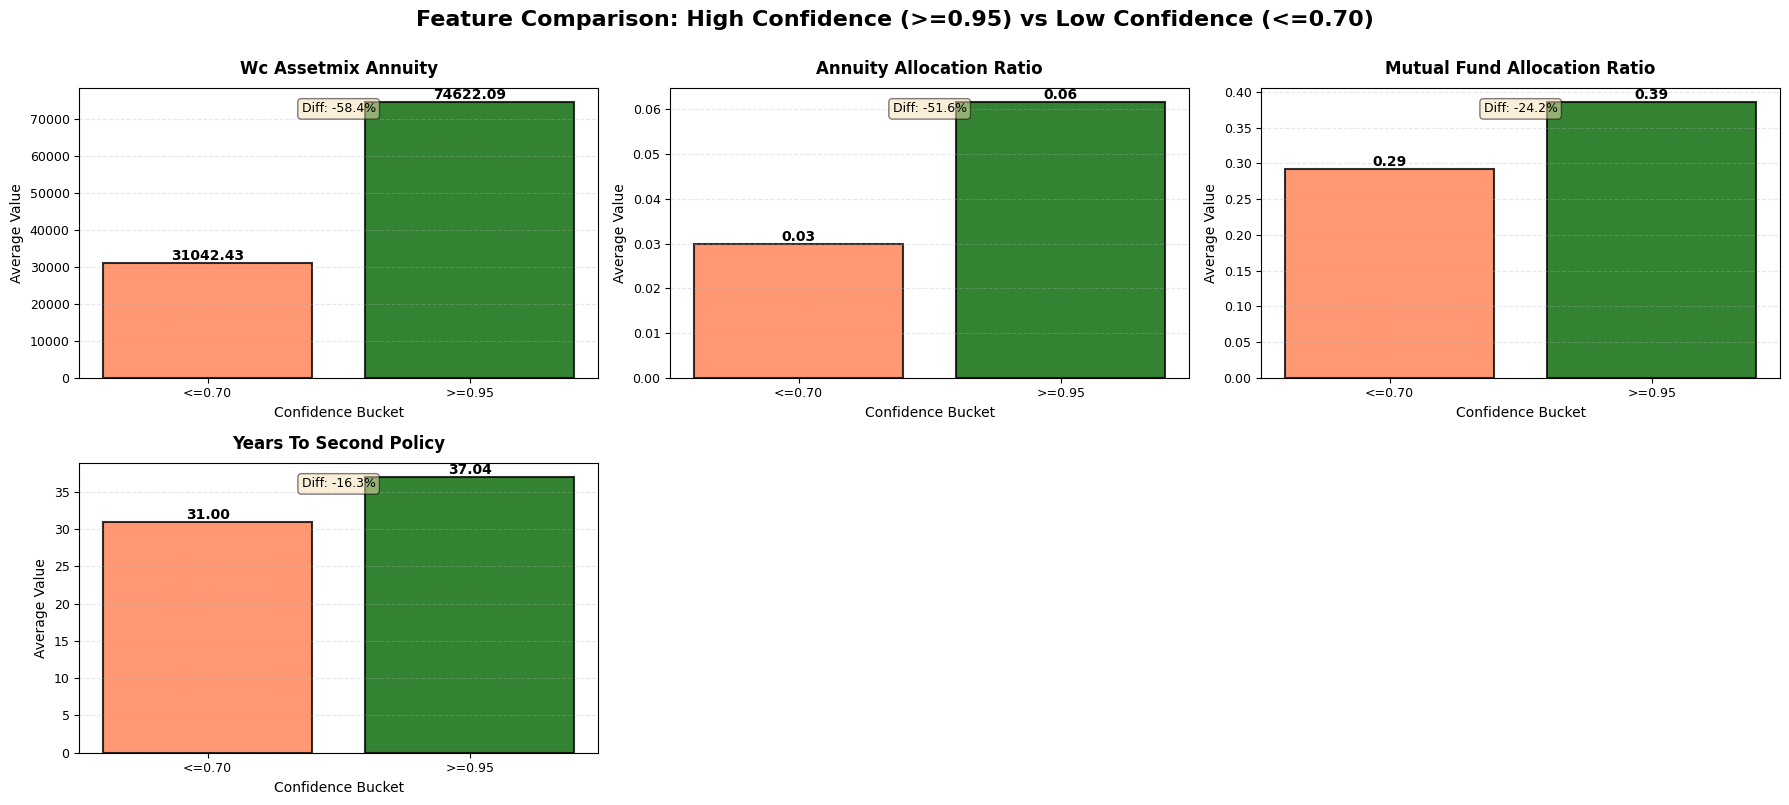

In [0]:
#  Major differentiators for >=95% confidence predictions

from pyspark.sql import functions as F

# Get most recent business_month
pred_table = "eda_smartlist.us_wealth_management_smartlist.ML_predictions_single_policy"
source_table = "dl_tenants_daas.us_wealth_management.wealth_management_client_metrics"

max_month = spark.table(pred_table).agg(F.max("business_month")).first()[0]
print(f"Loading data for business_month={max_month}")

# Load predictions
df_pred = spark.table(pred_table).filter(F.col("business_month") == max_month)
print(f"Predictions count: {df_pred.count():,}")

# Load source data and compute derived features (filter to most recent business_month)
df_source = spark.table(source_table).filter(F.col("business_month") == max_month)

# Compute allocation ratios
df_source = df_source.withColumn(
    "stock_allocation_ratio",
    F.col("wc_assetmix_stocks") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_source = df_source.withColumn(
    "bond_allocation_ratio",
    F.col("wc_assetmix_bonds") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_source = df_source.withColumn(
    "annuity_allocation_ratio",
    F.col("wc_assetmix_annuity") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_source = df_source.withColumn(
    "mutual_fund_allocation_ratio",
    F.col("wc_assetmix_mutual_funds") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)

# Compute age_at_first_policy and years_to_second_policy
df_source = df_source.withColumn("register_ts", F.to_timestamp("register_date"))
df_source = df_source.withColumn("birth_ts", F.to_timestamp("isrd_brth_date"))
df_source = df_source.withColumn(
    "age_at_first_policy",
    F.datediff(F.col("register_ts"), F.col("birth_ts")) / 365.25
)
df_source = df_source.withColumn(
    "years_to_second_policy",
    F.datediff(F.current_timestamp(), F.col("register_ts")) / 365.25
)

# Features to select from source table
features_from_source = [
    "wc_assetmix_annuity",
    "annuity_allocation_ratio",
    "mutual_fund_allocation_ratio",
    "years_to_second_policy"
]

# Join predictions with source data on axa_party_id (source data is already filtered to most recent business_month)
df_joined = df_pred.join(
    df_source.select("axa_party_id", *features_from_source), 
    on="axa_party_id", 
    how="inner"
)
print(f"Joined data count: {df_joined.count():,}")

# Create buckets
df_buckets = df_joined.withColumn(
    "prob_bucket",
    F.when(F.col("pred_prob") >= 0.95, ">=0.95")
     .when(F.col("pred_prob") <= 0.70, "<=0.70")
     .otherwise(None)
).filter(F.col("prob_bucket").isNotNull())

print(f"Bucketed data count: {df_buckets.count():,}")

# All features to analyze (including psn_age from predictions table)
# all_features = features_from_source + ["psn_age"]
all_features = features_from_source

# Compute average for each feature in each bucket
avg_exprs = [F.avg(F.col(f)).alias(f) for f in all_features]
df_avg = df_buckets.groupBy("prob_bucket").agg(*avg_exprs).orderBy("prob_bucket")

# Display comparison table
print("\nAverage Feature Values by Confidence Bucket:")
display(df_avg)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Melt for visualization
df_avg_pd = df_avg.toPandas()
df_melt = df_avg_pd.melt(id_vars=["prob_bucket"], value_vars=all_features, var_name="feature", value_name="avg_value")

print("\nDetailed Feature Comparison:")
display(df_melt)

# ============================================================================
# SEPARATE VISUALIZATIONS FOR EACH FEATURE
# ============================================================================

print("\n" + "=" * 80)
print("INDIVIDUAL FEATURE COMPARISONS")
print("=" * 80)

# Calculate grid dimensions
num_features = len(all_features)
cols = 3
rows = (num_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten() if num_features > 1 else [axes]

for idx, feature in enumerate(all_features):
    ax = axes[idx]
    
    # Get data for this feature
    feature_data = df_melt[df_melt["feature"] == feature]
    
    # Create bar chart
    buckets = feature_data["prob_bucket"].values
    values = feature_data["avg_value"].values
    colors = ["darkgreen" if b == ">=0.95" else "coral" for b in buckets]
    
    bars = ax.bar(buckets, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Styling
    ax.set_title(feature.replace('_', ' ').title(), fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('Average Value', fontsize=10)
    ax.set_xlabel('Confidence Bucket', fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='both', labelsize=9)
    
    # Calculate and display percentage difference
    if len(values) == 2:
        pct_diff = ((values[0] - values[1]) / values[1] * 100) if values[1] != 0 else 0
        diff_text = f"Diff: {pct_diff:+.1f}%"
        ax.text(0.5, 0.95, diff_text, transform=ax.transAxes, 
                ha='center', va='top', fontsize=9, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hide extra subplots
for idx in range(num_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Comparison: High Confidence (>=0.95) vs Low Confidence (<=0.70)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()